# Mask R-CNN for Keypoint Detection

Example showing how to do keypoint detection with Mask R-CNN

In [1]:
%matplotlib inline
import importlib
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

c:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load COCO Datasets for Keypoint Detection

In [2]:
# Import COCO classes
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))

import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare dataset
dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True)
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True)
dataset_val.prepare()

Will use images in A:/Programming/DeepLearningDatasets/coco/train2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=9.76s)
creating index...
index created!
Will use images in A:/Programming/DeepLearningDatasets/coco/val2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


### Setup Training

In [3]:
class TrainConfig(Config):
    NAME = "coco_keypoints"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1 # IMAGES_PER_GPU = 2
    GPU_COUNT = 1
    
    # We use resnet50
    BACKBONE = "resnet50"
    
    # Set number of classes
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    
    # DEBUG:
    STEPS_PER_EPOCH = 10
    
    USE_MINI_MASK = False
    TRAIN_ROIS_PER_IMAGE = 100
    #MAX_GT_INSTANCES = 2

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]

In [4]:
importlib.reload(modellib)

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   #exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_mask"])

Shapes
target_mask.shape (1, ?, ?, ?, ?)
1
target_masks.shape (1, ?, ?, ?, ?)
target_kp_ids.shape (1, ?, 17)
pred_masks.shape (?, 100, 28, 28, 17)
2
target_masks.shape (?, ?, ?)
pred_masks.shape (?, ?, ?)
y_true.shape (?, ?, ?)
y_pred.shape (?, ?, ?)
loss Tensor("mrcnn_mask_loss/cond/Merge:0", dtype=float32)
1
target_masks.shape (?, 100, 28, 28, 17)
target_kp_ids.shape (?, 17)
pred_masks.shape (?, 100, 28, 28, 17)
2
target_masks.shape (?, ?, ?)
pred_masks.shape (?, ?, ?)
y_true.shape (?, ?, ?)
y_pred.shape (?, ?, ?)
loss Tensor("mrcnn_mask_loss/cond_1/Merge:0", dtype=float32)


## Train

In [5]:
# Training - Stage 1
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers="heads")

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: A:\Programming\Pose_RCNN\logs\coco_keypoints20180528T0031\mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mas

c:\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
10/10 [==============================] - 680s 68s/step - loss: 2.3615 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.8038 - mrcnn_class_loss: 0.6775 - mrcnn_bbox_loss: 0.8077 - mrcnn_mask_loss: 0.0348 - val_loss: 2.0457 - val_rpn_class_loss: 0.0465 - val_rpn_bbox_loss: 0.6045 - val_mrcnn_class_loss: 0.4228 - val_mrcnn_bbox_loss: 0.9112 - val_mrcnn_mask_loss: 0.0607

Explanation of losses:

- rpn_class_loss: "How well does the network separate positive from negative anchors?"
- rpn_bbox_loss: "How accurate are proposed the bounding boxes?"
- mrcnn_class_loss: "How well does the network distinguish people from background RoIs?" (really, this is the same as 1.)
- mrcnn_bbox_loss: "Bounding box refinement loss" (is this the same as 2.?)
- mrcnn_mask_loss: "How accurate are the predicted keypoints?" (per mask softmax cross-entropy loss)

In [10]:
print("Done")

Done


In [11]:
class InferenceConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    USE_MINI_MASK = False
    #MAX_GT_INSTANCES = 2
    
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
M

In [12]:
importlib.reload(modellib)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  A:\Programming\Pose_RCNN\logs\coco_keypoints20180528T0031\mask_rcnn_coco_keypoints_0001.h5


## Inspect Model

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
gt_class_ids             shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_kp_ids                shape: (1, 17)               min:    1.00000  max:   17.00000  int32
gt_bbox                  shape: (1, 4)                min:  144.00000  max:  879.00000  int32
gt_masks                 shape: (1, 1024, 1024, 17)   min:    0.00000  max:    1.00000  bool


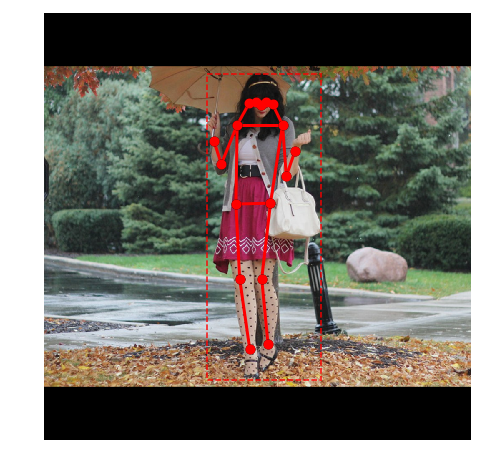

In [13]:
importlib.reload(modellib)
importlib.reload(visualize)

# Load a test image
image_id = dataset_val.image_ids[10]

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_bbox, gt_kp_masks, gt_kp_ids = \
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_kp_ids", gt_kp_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_kp_masks)

visualize.display_keypoints(image, gt_bbox, gt_kp_masks, gt_kp_ids,
                            figsize=(8, 8), skeleton=dataset_train.skeleton)

In [14]:
def verify_masks(masks):
    if len(masks.shape) == 3: masks = np.expand_dims(masks, axis=0)
    for i in range(masks.shape[0]):
        for j in range(masks.shape[-1]):
            if np.sum(masks[i, :, :, j]) > 1:
                print("Mask [%i, :, :, %i] sum = %i" % (i, j, np.sum(masks[i, :, :, j])))
verify_masks(gt_kp_masks)

In [15]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

results = model.detect([image], verbose=1)
r = results[0]

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
mrcnn_mask.dtype float32
detections.shape (100, 6)
mrcnn_mask.shape (100, 28, 28, 17)
masks.shape (23, 28, 28, 17)
(23, 28, 28)


(23, 1024, 1024, 17)
float64
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
class_ids                shape: (23,)                 min:    1.00000  max:    1.00000  int32
kp_ids                   shape: (12, 17)              min:    0.00000  max:   16.00000  int32
bbox                     shape: (23, 4)               min:    0.00000  max: 1024.00000  int32
masks                    shape: (23, 1024, 1024, 17)  min:    0.00000  max:    0.99678  float64


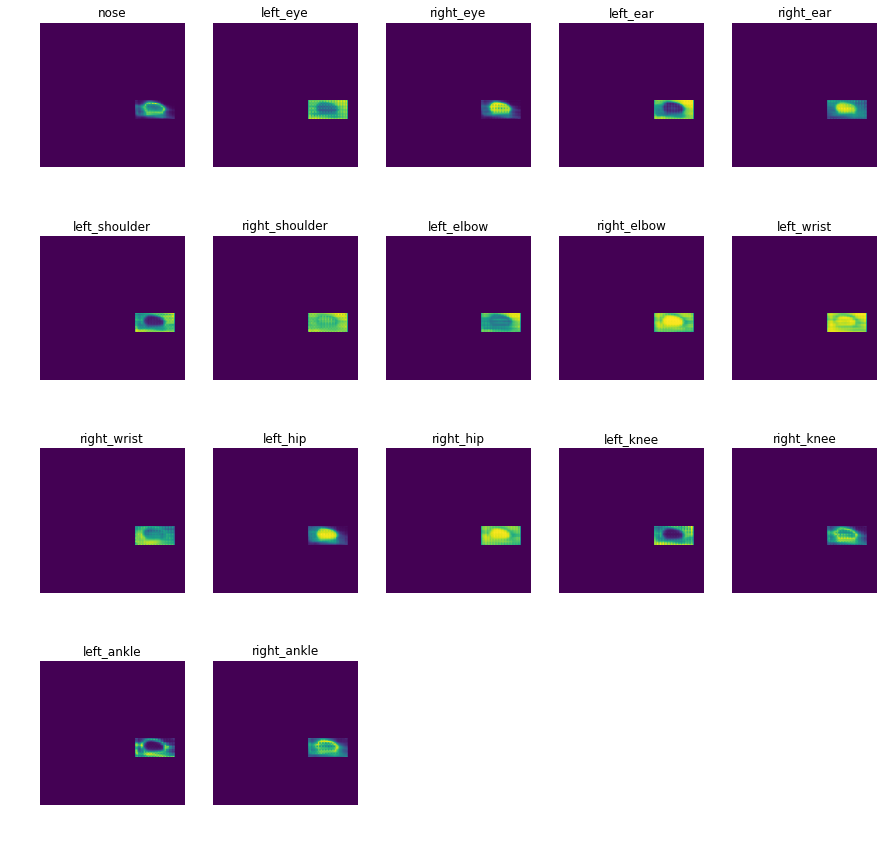

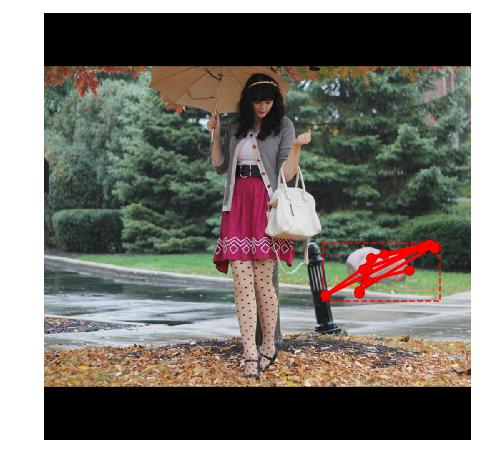

In [25]:
masks = r["masks"]
print(masks.shape)
print(masks.dtype)

#verify_masks(masks)

bbox, kp_masks, kp_ids = r["rois"], r["masks"], np.repeat(np.expand_dims(np.arange(17), axis=0), 12, axis=0)

log("image", image)
log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", masks)

%matplotlib inline
import matplotlib.pyplot as plt

_, axes = plt.subplots(4, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    if i >= 17: continue
    #x, y = i % 4, i // 4
    
    ax.set_title(dataset_train.kp_class_names[i+1])
    ax.imshow(masks[0, :, :, i])


plt.show()

visualize.display_keypoints(image, bbox[0:1], kp_masks[0:1],
                            figsize=(8, 8), skeleton=dataset_train.skeleton)

In [20]:
print(r['class_ids'])
print(r["scores"])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.90425897 0.8629516  0.855562   0.85192543 0.82080215 0.8051267
 0.77715915 0.75730157 0.73698366 0.7168771  0.6983307  0.6899604
 0.67547107 0.63979906 0.63902444 0.6256816  0.59984183 0.5828905
 0.56382596 0.55563086 0.5475628  0.52190197 0.5168771 ]


In [ ]:
#visualize.display_keypoints(original_image, r['rois'], r['masks'], r['class_ids'],
#                            dataset_val.class_names, skeleton=None)

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([original_image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
#print(det_class_ids)
#det_count = np.where(det_class_ids == 0)[0][0]
#det_class_ids = det_class_ids[:det_count]

#print("{} detections: {}".format(
#    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [ ]:
visualize.display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")